#Классификация по тональности
В задании предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

In [ ]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:17, 1458.46it/s]



Посмотрим на пример отзыва:

In [ ]:
responses[69]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Сбербанк-онлайн',
 'num_comments': 3,
 'bank_license': 'лицензия № 1481',
 'author': 'maxpant',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-06-07 22:58:19',
 'text': 'С удивлением узнал, что в Сбербанке-онлайн невозможно изменить пароль на свой собственный. Честно, говоря - это очень странное решение. Конечно случайный набор букв и цифр на первый взгляд - более безопасный пароль. Но эту белиберду невозможно запомнить! Придется записать. А записанный пароль - это уже прокол в безопасности.',
 'rating_grade': None}

In [ ]:
df = pd.DataFrame(responses)
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


##Часть 1. Анализ текстов
1) Посчитайте количество отзывов в разных городах и на разные банки

2) Постройте гистограмы длин слов в символах и в словах

3) Найдите 10 самых частых:

--слов

--слов без стоп-слов

--лемм

--существительных

4) Постройте кривые Ципфа и Хипса

5) Ответьте на следующие вопросы:

какое слово встречается чаще, "сотрудник" или "клиент"?
сколько раз встречается слова "мошенничество" и "доверие"?

6) В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру
, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
# кол-во отзывов
len(df['text'])

153499

In [ ]:
# кол-во городов
len(df['city'].unique())

5824

In [ ]:
# кол-во банков
len(df['bank_name'].unique())

670

In [ ]:
# на какие банки больше всего жалоб
df['bank_name'].value_counts()

bank_name
Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: count, Length: 670, dtype: int64

In [ ]:
# по каким городам больше всего жалоб
df['city'].value_counts()

city
г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: count, Length: 5823, dtype: int64

In [ ]:
# Извлекаем необходимые данные
texts = df['text'][:5000]

###Гистограмма

In [ ]:
# Определяем количество символов в каждом отзыве
char_counts = [len(text.split()) for text in texts]
char_counts

[219,
 140,
 90,
 123,
 306,
 82,
 88,
 102,
 95,
 200,
 252,
 813,
 52,
 233,
 245,
 98,
 152,
 108,
 392,
 339,
 220,
 400,
 248,
 59,
 48,
 42,
 121,
 47,
 50,
 41,
 31,
 117,
 742,
 313,
 157,
 130,
 203,
 258,
 281,
 48,
 94,
 100,
 293,
 97,
 162,
 102,
 121,
 108,
 323,
 215,
 158,
 149,
 57,
 206,
 118,
 78,
 84,
 165,
 41,
 94,
 51,
 238,
 38,
 353,
 341,
 170,
 48,
 59,
 336,
 48,
 98,
 399,
 172,
 46,
 280,
 115,
 185,
 149,
 121,
 225,
 142,
 87,
 123,
 49,
 79,
 56,
 243,
 243,
 97,
 189,
 86,
 130,
 312,
 91,
 265,
 76,
 72,
 407,
 56,
 66,
 143,
 732,
 217,
 45,
 74,
 39,
 145,
 437,
 301,
 189,
 396,
 122,
 218,
 59,
 167,
 32,
 232,
 158,
 54,
 145,
 53,
 134,
 186,
 624,
 139,
 345,
 89,
 136,
 59,
 340,
 285,
 60,
 388,
 22,
 46,
 246,
 54,
 126,
 189,
 120,
 183,
 136,
 101,
 57,
 168,
 169,
 51,
 52,
 92,
 463,
 61,
 940,
 153,
 53,
 191,
 60,
 250,
 128,
 160,
 274,
 373,
 85,
 185,
 271,
 48,
 109,
 147,
 120,
 160,
 412,
 254,
 185,
 62,
 56,
 436,
 229,
 110,
 

In [ ]:
# Определяем количество слов в каждом отзыве
word_counts = [len(text.split(' ')) for text in texts]
word_counts

[225,
 141,
 90,
 125,
 304,
 83,
 88,
 105,
 95,
 200,
 252,
 764,
 55,
 233,
 245,
 95,
 152,
 107,
 392,
 339,
 220,
 400,
 247,
 58,
 48,
 42,
 121,
 47,
 50,
 41,
 31,
 118,
 744,
 313,
 156,
 129,
 202,
 258,
 284,
 48,
 94,
 100,
 293,
 99,
 162,
 102,
 126,
 113,
 321,
 216,
 160,
 149,
 57,
 206,
 118,
 79,
 83,
 166,
 41,
 94,
 51,
 240,
 38,
 345,
 343,
 167,
 48,
 59,
 336,
 48,
 98,
 398,
 172,
 46,
 280,
 115,
 184,
 149,
 121,
 219,
 146,
 87,
 122,
 49,
 79,
 56,
 244,
 243,
 97,
 188,
 85,
 130,
 316,
 91,
 265,
 78,
 72,
 406,
 56,
 66,
 143,
 730,
 217,
 45,
 74,
 39,
 145,
 438,
 301,
 189,
 404,
 122,
 218,
 57,
 167,
 32,
 227,
 157,
 55,
 146,
 52,
 124,
 184,
 624,
 139,
 345,
 89,
 135,
 59,
 337,
 285,
 60,
 388,
 26,
 46,
 245,
 54,
 121,
 189,
 120,
 181,
 137,
 101,
 57,
 169,
 169,
 51,
 52,
 92,
 464,
 58,
 939,
 153,
 53,
 185,
 60,
 250,
 131,
 162,
 292,
 374,
 84,
 186,
 273,
 48,
 109,
 151,
 120,
 160,
 414,
 252,
 182,
 60,
 55,
 441,
 227,
 110,
 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Построим гистограммы
char_count_series = pd.Series(char_counts)
word_count_series = pd.Series(word_counts)

Гистограмма длины отзыва в символах

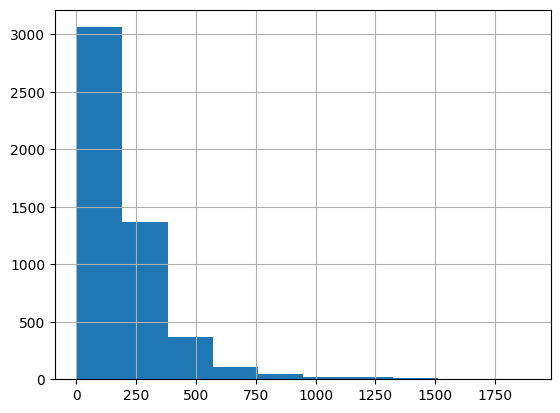

In [ ]:
char_count_series.hist()

plt.show()

Гистограмма длины отзыва в словах

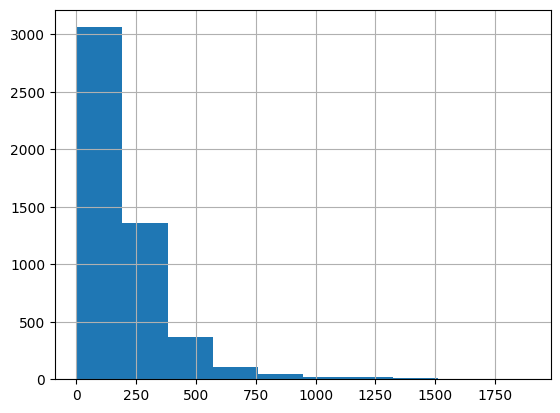

In [ ]:
word_count_series.hist()

plt.show()

In [ ]:
from collections import Counter

In [ ]:
df['text'].head().tolist()

['Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют м

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
all_text = ' '.join(texts)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Токенизация текста
tokens = word_tokenize(all_text)

In [ ]:
# Удаление пунктуации и приведение к нижнему регистру
words = [word.lower() for word in tokens if word.isalnum()]

# Удаление пунктуации
tokens = [word for word in tokens if word.isalnum()]

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
stopwords.words('russian')

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [ ]:
# Удаление стоп-слов
stop_words = set(stopwords.words('russian'))
filtered_words = [word for word in words if word not in stop_words]

###10 самых частых слов

In [ ]:
# Подсчет частоты слов
word_counts = Counter(filtered_words)
word_counts.most_common(10)

[('банка', 8243),
 ('банк', 6303),
 ('это', 5057),
 ('деньги', 3422),
 ('карты', 3046),
 ('карту', 2912),
 ('день', 2393),
 ('кредит', 2352),
 ('заявление', 1916),
 ('банке', 1863)]

In [ ]:
from nltk.probability import FreqDist

###10 самых частых слов без стоп слов

In [ ]:
tokens_without_stopwords = [word for word in tokens if word not in stop_words]

In [ ]:
word_counts_without_stopwords = Counter(tokens_without_stopwords)

In [ ]:
word_counts_without_stopwords.most_common(10)

[('банка', 7170),
 ('банк', 4897),
 ('это', 4379),
 ('В', 4335),
 ('Я', 4010),
 ('деньги', 3195),
 ('карты', 3002),
 ('карту', 2821),
 ('день', 2362),
 ('кредит', 2099)]

###10 самых частых лемм

In [ ]:
pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 906.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c2171dbad20ef72b4bc393c5b12a577cee17f63ef57af454dc8cbb58be701660
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

In [ ]:
# Лемматизация текста
try:
    lemmas = [morph.parse(w)[0].normal_form for w in all_text.split(' ')]
    # Подсчет частоты лемм
    counter = Counter(lemmas)
    print(counter.most_common(10))
except:
    print("Ошибка при лемматизации текста.")

[('в', 36363), ('я', 30521), ('и', 29293), ('не', 24451), ('на', 19805), ('что', 17482), ('с', 15083), ('банк', 12574), ('по', 10829), ('быть', 10716)]


###10 самых частых сущ

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
try:
    lemmas = [morph.parse(w)[0].normal_form for w in all_text.split(' ')]
    nouns = [lemma for lemma in lemmas if morph.parse(lemma)[0].tag.POS == 'NOUN']
    # Подсчет частоты существительных
    counter = Counter(nouns)
    print(counter.most_common(10))
except:
    print("Ошибка при анализе текста.")

[('банк', 12574), ('карта', 6370), ('сотрудник', 3686), ('деньга', 3261), ('мочь', 3033), ('кредит', 2933), ('сумма', 2654), ('отделение', 2650), ('день', 2587), ('счёт', 2532)]


Чаще встречалось существительное "сотрудник", чем "клиент"

###Построение кривой Ципфа и Хипса

In [ ]:
# Функция для подсчета кривой Ципфа
def zipf_curve(text):
    word_freq = nltk.FreqDist(text)
    sorted_freq = sorted(word_freq.values(), reverse=True)
    ranks = np.arange(1, len(sorted_freq) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, sorted_freq, marker='o', linestyle='-')
    plt.title('Кривая Ципфа')
    plt.xlabel('Ранг слова')
    plt.ylabel('Частота слова')
    plt.show()

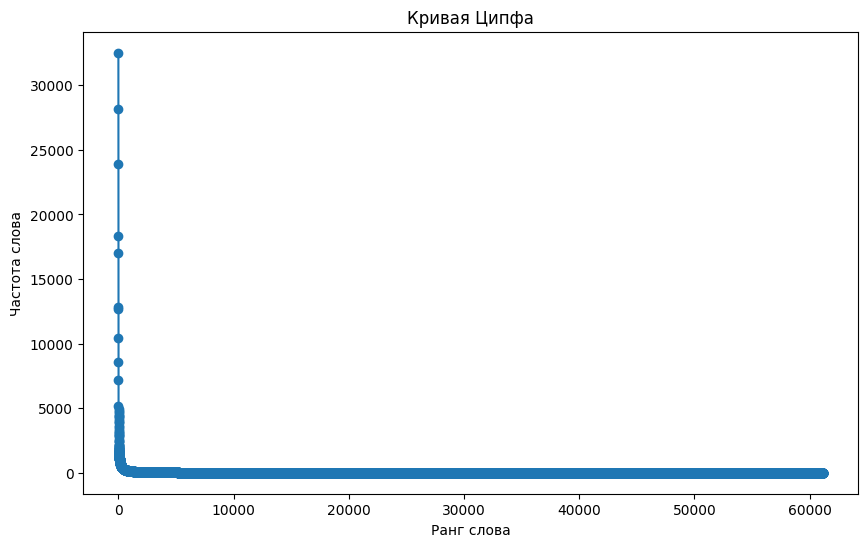

In [ ]:
zipf_curve(tokens)

In [ ]:
# Функция для подсчета кривой Хипса
def heaps_curve(text):
    corpus = []
    vocab_sizes = []
    words_seen = set()
    for word in text:
        words_seen.add(word)
        corpus.append(len(words_seen))
        vocab_sizes.append(len(words_seen))
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(corpus)), vocab_sizes, marker='o', linestyle='-')
    plt.title('Кривая Хипса')
    plt.xlabel('Размер корпуса')
    plt.ylabel('Размер словаря')
    plt.show()

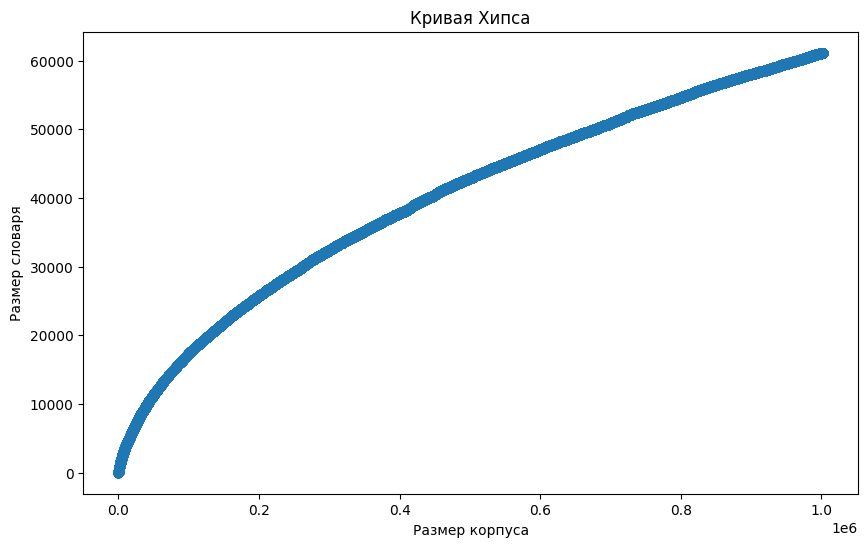

In [ ]:
heaps_curve(tokens)

##Часть 2. Тематическое моделирование
1) Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

2) Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [ ]:
from pymystem3 import Mystem
m = Mystem()

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils, models
import gensim

In [ ]:
import re

In [ ]:
ru_words = re.compile("[А-Яа-я]+")

m = Mystem()

def words_only(text):
    return " ".join(ru_words.findall(text))

def lemmatize(text, mystem=m):
    try:
        return " ".join([m.lemmatize(w)[0] for w in text.split(' ')])
    except:
        return " "

def remove_stopwords(text, mystopwords = stop_words):
    try:
        return " ".join([token for token in text.split(' ') if not token in mystopwords])
    except:
        return ""

def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [ ]:
df.text

0         Добрый день! Я не являюсь клиентом банка и пор...
1         Доброго дня! Являюсь держателем зарплатной кар...
2         Здравствуйте!  Дублирую свое заявление от 03.0...
3         Добрый день!! Я открыл расчетный счет в СберБа...
4         04.03.2015 г. взяла кредит в вашем банке, заяв...
                                ...                        
153494    Слишком большой банк, не всегда учитывает нашу...
153495    Вы сами виноваты в своих проблемах, кроме пред...
153496    Уважаемое руководство банка «ОВК»! Я проживаю ...
153497    Пробовала 10.04.05 оформить товар в кредит в А...
153498    Если коротко, то мне нравится. Кридит получать...
Name: text, Length: 153499, dtype: object

In [ ]:
limitedDf = df.iloc[:5000].text

In [ ]:
%%time
limitedDf = limitedDf.apply(preprocess)

CPU times: user 40.3 s, sys: 10.3 s, total: 50.5 s
Wall time: 2min 32s


In [ ]:
limitedDf

0         добрый день являться клиент банка поручитель к...
1         добрый день являться держатель зарплатной карт...
2         здравствовать дублировать свое заявление можай...
3         добрый день открывать расчетный счет сбербанк ...
4         г взять кредит ваш банк заявлять сумма т рубль...
                                ...                        
153494                                                  NaN
153495                                                  NaN
153496                                                  NaN
153497                                                  NaN
153498                                                  NaN
Name: text, Length: 153499, dtype: object

In [ ]:
# print(df.text)
# for text in df.iloc[:25].text:
#   print(text)

texts = [text.split() for text in limitedDf]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
corpus

[[(0, 3),
  (1, 2),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 2),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 3),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 4),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 2),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 3),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 2),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 3),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

In [ ]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
corpus_tfidf

In [ ]:
import warnings

In [ ]:
# %%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [ ]:
len(corpus)

5000

In [ ]:
sims[0]

array([1.0000001 , 0.01014715, 0.01843617, ..., 0.05192766, 0.03028482,
       0.02795   ], dtype=float32)

In [ ]:
from gensim.models import lsimodel

In [ ]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 2.52 s, sys: 778 ms, total: 3.3 s
Wall time: 2.77 s


###Темы

In [ ]:
lsi.show_topics(5)

[(0,
  '0.189*"карта" + 0.136*"кредит" + 0.115*"деньги" + 0.110*"вклад" + 0.102*"счет" + 0.100*"заявление" + 0.099*"отделение" + 0.098*"сумма" + 0.096*"сотрудник" + 0.095*"сбербанк"'),
 (1,
  '-0.274*"вклад" + 0.253*"звонок" + 0.225*"номер" + -0.209*"карта" + 0.191*"ваш" + 0.181*"кредит" + 0.151*"телефон" + 0.128*"звонить" + 0.127*"персональный" + -0.124*"банкомат"'),
 (2,
  '0.652*"вклад" + -0.205*"карта" + 0.202*"ставка" + 0.161*"договор" + -0.161*"банкомат" + -0.150*"сбербанк" + 0.146*"условие" + 0.131*"пополнение" + 0.130*"открывать" + 0.115*"процент"'),
 (3,
  '-0.373*"страховка" + -0.302*"кредит" + -0.294*"страхование" + 0.215*"вклад" + 0.198*"номер" + -0.153*"договор" + -0.148*"страховой" + 0.140*"звонок" + -0.127*"погашение" + 0.121*"карта"'),
 (4,
  '0.197*"средство" + 0.186*"платеж" + -0.178*"заявка" + 0.168*"денежный" + 0.166*"сумма" + 0.145*"счет" + 0.134*"договор" + -0.131*"отделение" + 0.130*"руб" + 0.129*"задолженность"')]

In [ ]:
topics = lsi.show_topics(num_topics=5)

In [ ]:
banks = ['Сбербанк России', 'ВТБ 24', 'Русский Стандарт', 'Альфа-Банк']

In [ ]:
# Проходим по каждой теме и ищем упоминания банков
for topic_id, topic in topics:
    terms = [term.split('*')[1].strip() for term in topic.split('+')]
    for bank in banks:
        if any(bank.lower() in term.lower() for term in terms):
            print(f"Тема {topic_id} содержит упоминание банка '{bank}'")
            print("Термины темы:", terms)
            print("\n")

Тема 0 содержит упоминание банка 'Сбербанк России'
Термины темы: ['"карта"', '"кредит"', '"деньги"', '"вклад"', '"счет"', '"заявление"', '"отделение"', '"сумма"', '"сотрудник"', '"сбербанк"']


Тема 0 содержит упоминание банка 'ВТБ 24'
Термины темы: ['"карта"', '"кредит"', '"деньги"', '"вклад"', '"счет"', '"заявление"', '"отделение"', '"сумма"', '"сотрудник"', '"сбербанк"']


Тема 0 содержит упоминание банка 'Русский Стандарт'
Термины темы: ['"карта"', '"кредит"', '"деньги"', '"вклад"', '"счет"', '"заявление"', '"отделение"', '"сумма"', '"сотрудник"', '"сбербанк"']


Тема 0 содержит упоминание банка 'Альфа-Банк'
Термины темы: ['"карта"', '"кредит"', '"деньги"', '"вклад"', '"счет"', '"заявление"', '"отделение"', '"сумма"', '"сотрудник"', '"сбербанк"']


Тема 1 содержит упоминание банка 'Сбербанк России'
Термины темы: ['"вклад"', '"звонок"', '"номер"', '"карта"', '"ваш"', '"кредит"', '"телефон"', '"звонить"', '"персональный"', '"банкомат"']


Тема 1 содержит упоминание банка 'ВТБ 24'
Тер

In [ ]:
import seaborn as sns

<ipython-input-180-ddec57c1c5f0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


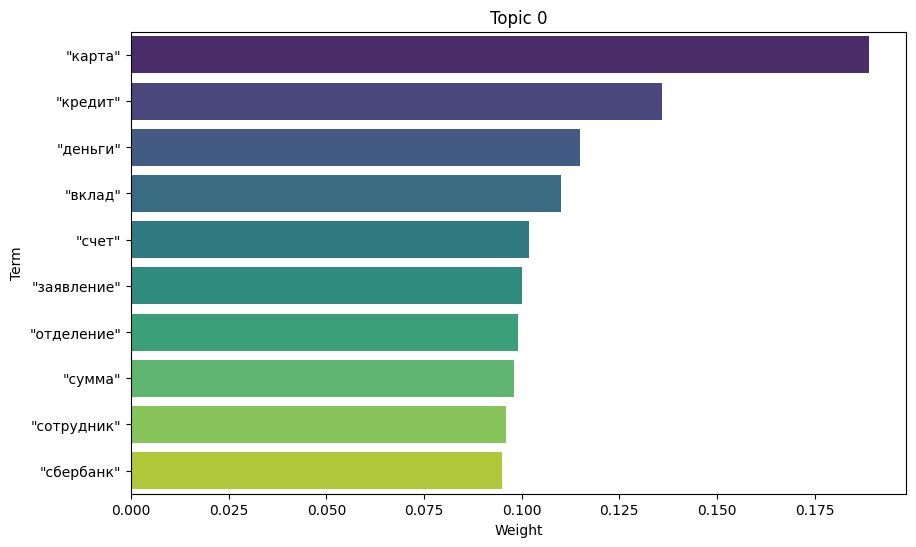

<ipython-input-180-ddec57c1c5f0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


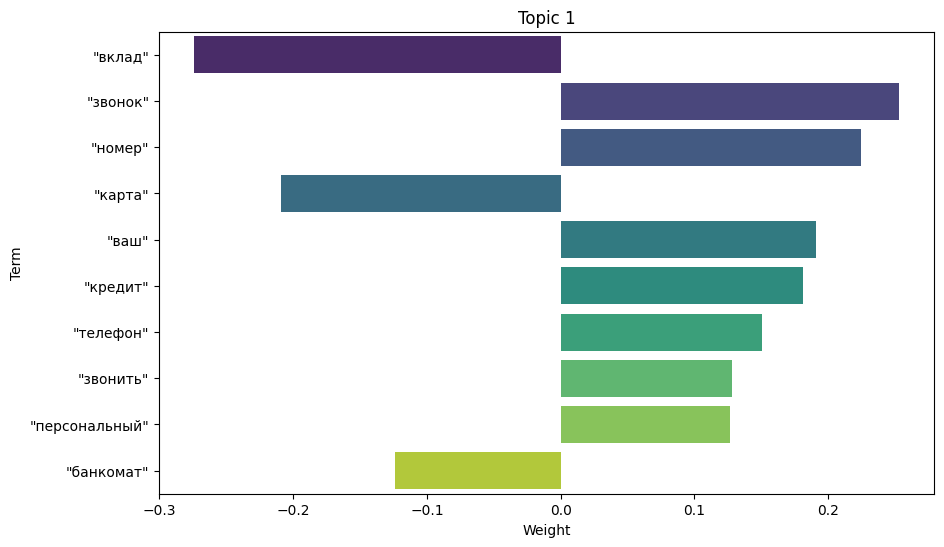

<ipython-input-180-ddec57c1c5f0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


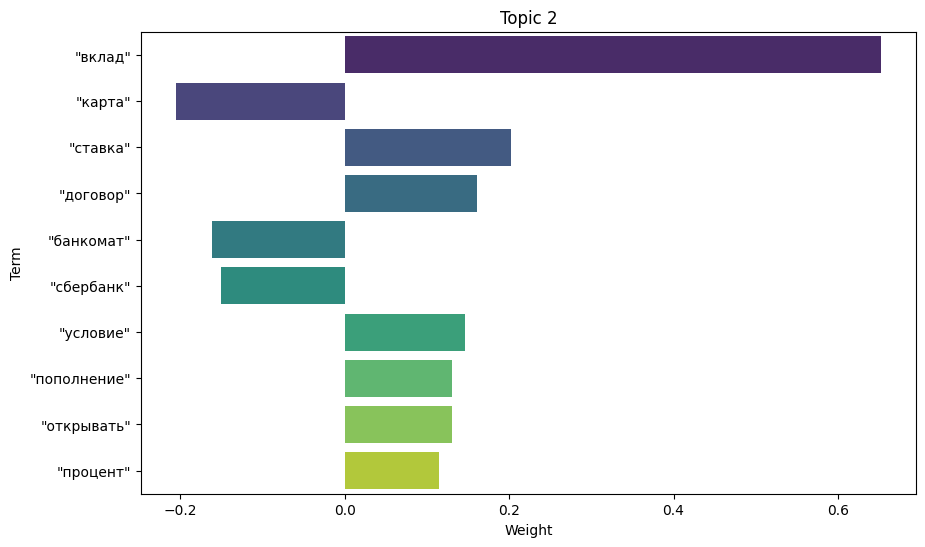

<ipython-input-180-ddec57c1c5f0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


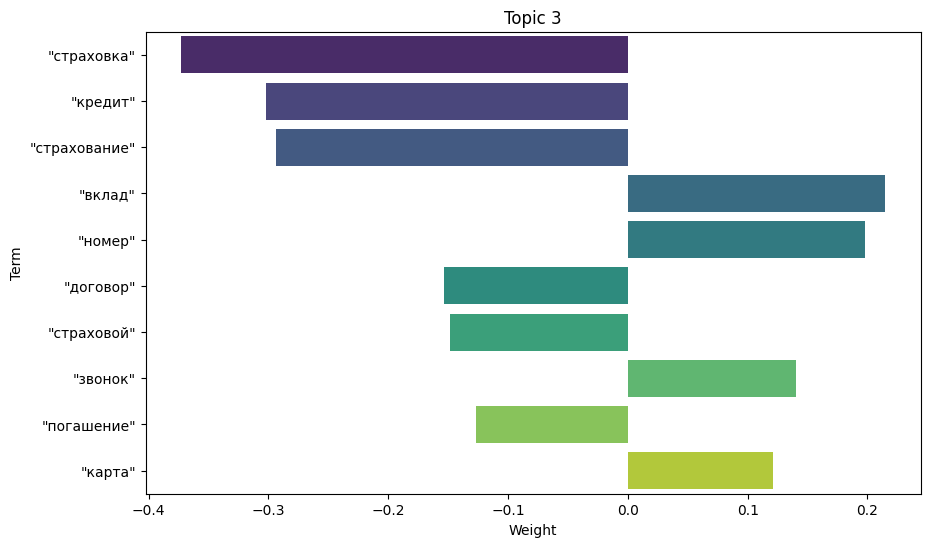

<ipython-input-180-ddec57c1c5f0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


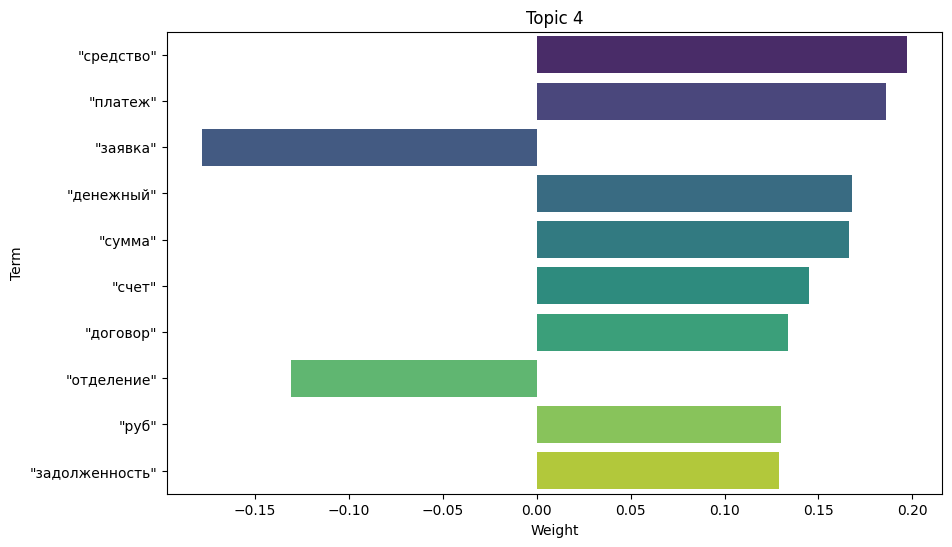

In [ ]:
for topic_id, topic in topics:
    terms = [term.split('*')[1].strip() for term in topic.split('+')]
    weights = [float(term.split('*')[0]) for term in topic.split('+')]

    # Создание DataFrame для визуализации
    df_topic = pd.DataFrame({'Term': terms, 'Weight': weights})

    # Построение столбчатой диаграммы для текущей темы
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')
    plt.title(f'Topic {topic_id}')
    plt.xlabel('Weight')
    plt.ylabel('Term')
    plt.show()

##Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1) Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

2) Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных
-грам.

3) Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант:
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

* 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [ ]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [ ]:
# Выбор отзывов с оценкой 1
negative_reviews = df[df['rating_grade'] == 1].sample(n=3000, random_state=42)
negative_reviews

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
69869,г. канск,False,Не пришли деньги на карту,4,лицензия № 1481,dfibyf,Сбербанк России,2013-10-24 11:46:00,Здравствуйте! Я тоже не довольна работой сберб...,1.0
107901,г. Ростов-на-Дону,False,Ввели в заблуждение,6,лицензия № 1961,liyulia,Связной Банк,2012-05-21 02:52:00,Я пользуюсь кредитной картой Связной Банк уже ...,1.0
34024,г. Москва,False,Банк для телепатов,3,лицензия № 967,nunyatka,Балтика,2014-09-17 15:18:00,Меняла номер телефона для смс уведомлений об о...,1.0
146036,None,False,Несостоявшееся открытие р/счетов,0,лицензия № 1439,GLBuh555,Возрождение,2007-11-16 15:30:00,Наша организация решила открыть второй расчетн...,1.0
42935,г. Москва,False,Резко отрицательное впечатление,1,лицензия № 2999,Теневая экономка,СБ Банк (Судостроительный банк),2014-06-26 11:33:00,Знакомство с банком началось с изучения сайта....,1.0
...,...,...,...,...,...,...,...,...,...,...
48762,г. Липецк,False,О MnogoCard от банка Открытие,0,лицензия № 1971,TraderBankir,Ханты-Мансийский банк Открытие,2014-05-01 18:30:00,"1. Спасибо, сайту banki.ru, где объективно мож...",1.0
129845,г. Москва,False,Банкомат не зачислил денег на карту,12,лицензия № 1481,parusprof,Сбербанк России,2010-10-31 15:48:00,Худший банк в России. 15 октября 2010 года вно...,1.0
54715,г. Владивосток,False,Банкомат Сбербанка съел деньги не зачислив их ...,4,лицензия № 1481,ОЛЬГА2222,Сбербанк России,2014-03-12 05:08:00,03.03.2014 примерно в 13.00 в банкомате № 2546...,1.0
17657,г. Тула,False,"Сотрудники Сбербанка не знают, как получить за...",0,лицензия № 1481,Marina711,Сбербанк России,2015-01-16 12:42:00,17 декабря 2014 года мною был досрочно погашен...,1.0


In [ ]:
# Выбор отзывов с оценкой 5
positive_reviews = df[df['rating_grade'] == 5].sample(n=3000, random_state=42)
positive_reviews

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
82327,г. Москва,False,Плюсы сотрудничества,1,лицензия № 2748,13frodizak13,Банк Москвы,2013-06-04 13:20:00,Добрый день! Решил тоже оставить свои впечатле...,5.0
129189,г. Ярославль,False,Спасибо Юлии Яблоковой!,0,лицензия № 3279,suvorovyar,Национальный Банк «Траст»,2010-12-03 13:06:00,"Так получилось, что полученный на карточку кре...",5.0
152238,None,False,Осторожно,1,лицензия № 3292,Антон,Райффайзенбанк,2005-09-21 14:21:00,"Уже писал про свое путешествие в ""Райффайзен"" ...",5.0
111273,г. Москва,False,Лучшее обслуживание VIP-клиентов юридических лиц,1,лицензия № 3171,миха,Межрегиональный Почтовый Банк,2012-03-14 00:23:00,Хочу поблагодарить отдел по работе с VIP-клиен...,5.0
150492,None,False,Кредитная карта,3,лицензия № 3292,Вячеслав,Райффайзенбанк,2006-04-12 22:17:00,Оформлял карту с льготным периодом кредитовани...,5.0
...,...,...,...,...,...,...,...,...,...,...
15159,г. Москва,False,Открытие вклада - быстро и чётко,0,лицензия № 2766,ver$iya,ОТП Банк,2015-02-04 01:05:00,"ОТП для меня новый банк, до этого в договорные...",5.0
114598,г. Санкт-Петербург,False,Кредит наличными: положительное удивление,2,лицензия № 2766,Evil Dead,ОТП Банк,2011-12-28 16:33:00,Всем доброго дня! Вот и сподобился я написать ...,5.0
148452,None,False,В Икеа Нижний Новгород кредит меня полностью ...,30,лицензия № 3354,verbicvik,Ренессанс Кредит,2007-01-20 17:56:00,"Я взяла диван в кредит в Икеа, была приятно уд...",5.0
21759,г. Москва,False,Офис Якиманка,0,лицензия № 2999,rous78,СБ Банк (Судостроительный банк),2014-12-22 12:32:00,Пользуюсь услугами этого банка уже более пяти ...,5.0


In [ ]:
# Объединение выбранных отзывов в один DataFrame
selected_reviews = pd.concat([negative_reviews, positive_reviews])
selected_reviews

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
69869,г. канск,False,Не пришли деньги на карту,4,лицензия № 1481,dfibyf,Сбербанк России,2013-10-24 11:46:00,Здравствуйте! Я тоже не довольна работой сберб...,1.0
107901,г. Ростов-на-Дону,False,Ввели в заблуждение,6,лицензия № 1961,liyulia,Связной Банк,2012-05-21 02:52:00,Я пользуюсь кредитной картой Связной Банк уже ...,1.0
34024,г. Москва,False,Банк для телепатов,3,лицензия № 967,nunyatka,Балтика,2014-09-17 15:18:00,Меняла номер телефона для смс уведомлений об о...,1.0
146036,None,False,Несостоявшееся открытие р/счетов,0,лицензия № 1439,GLBuh555,Возрождение,2007-11-16 15:30:00,Наша организация решила открыть второй расчетн...,1.0
42935,г. Москва,False,Резко отрицательное впечатление,1,лицензия № 2999,Теневая экономка,СБ Банк (Судостроительный банк),2014-06-26 11:33:00,Знакомство с банком началось с изучения сайта....,1.0
...,...,...,...,...,...,...,...,...,...,...
15159,г. Москва,False,Открытие вклада - быстро и чётко,0,лицензия № 2766,ver$iya,ОТП Банк,2015-02-04 01:05:00,"ОТП для меня новый банк, до этого в договорные...",5.0
114598,г. Санкт-Петербург,False,Кредит наличными: положительное удивление,2,лицензия № 2766,Evil Dead,ОТП Банк,2011-12-28 16:33:00,Всем доброго дня! Вот и сподобился я написать ...,5.0
148452,None,False,В Икеа Нижний Новгород кредит меня полностью ...,30,лицензия № 3354,verbicvik,Ренессанс Кредит,2007-01-20 17:56:00,"Я взяла диван в кредит в Икеа, была приятно уд...",5.0
21759,г. Москва,False,Офис Якиманка,0,лицензия № 2999,rous78,СБ Банк (Судостроительный банк),2014-12-22 12:32:00,Пользуюсь услугами этого банка уже более пяти ...,5.0


In [ ]:
# Разделение выбранных данных на обучающее и тестовое множества
X_train, X_test, y_train, y_test = train_test_split(selected_reviews['text'], selected_reviews['rating_grade'], test_size=0.2, random_state=42)

###Пайплайн

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# Определение классификатора
classifier = MultinomialNB()

In [ ]:
vectorizers = {
    "Униграмы": CountVectorizer(ngram_range=(1, 1)),
    "Биграмы": CountVectorizer(ngram_range=(1, 2)),
    "Триграмы": CountVectorizer(ngram_range=(1, 3))
}

In [ ]:
# Обучение и оценка каждого варианта векторизации
for name, vectorizer in vectorizers.items():
    # Создание пайплайна
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # Обучение классификатора и предсказание
    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)

    print(f"Векторизация: {name}")
    print(f"Точность на обучающем множестве: {train_score:.3f}")
    print(f"Точность на тестовом множестве: {test_score:.3f}")
    print("-------------------------------------")

Векторизация: Униграмы
Точность на обучающем множестве: 0.971
Точность на тестовом множестве: 0.923
-------------------------------------
Векторизация: Биграмы
Точность на обучающем множестве: 0.998
Точность на тестовом множестве: 0.922
-------------------------------------
Векторизация: Триграмы
Точность на обучающем множестве: 1.000
Точность на тестовом множестве: 0.919
-------------------------------------


###tf-idf + LSI и LDA

In [ ]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# 1-ый вариант: tf-idf + LSI
tfidf_lsi_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=30)),
    ('clf', RandomForestClassifier())
])

In [ ]:
# 2-ой вариант: LDA
lda_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation(n_components=30, random_state=42)),
    ('clf', RandomForestClassifier())
])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Обучение и оценка каждого пайплайна
for name, pipeline in [("tf-idf + LSI", tfidf_lsi_pipeline), ("LDA", lda_pipeline)]:
    # Обучение классификатора
    pipeline.fit(X_train, y_train)

    # Предсказание
    y_pred = pipeline.predict(X_test)

    # Оценка качества
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Вывод результатов
    print(f"Метод: {name}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-score: {f1:.3f}")
    print(classification_report(y_test, y_pred))
    print("----------------------------------------")

Метод: tf-idf + LSI
Accuracy: 0.886
F1-score: 0.886
              precision    recall  f1-score   support

         1.0       0.86      0.92      0.89       613
         5.0       0.91      0.85      0.88       587

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200

----------------------------------------
Метод: LDA
Accuracy: 0.852
F1-score: 0.851
              precision    recall  f1-score   support

         1.0       0.89      0.81      0.85       613
         5.0       0.82      0.90      0.86       587

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.86      0.85      0.85      1200

----------------------------------------
